In [33]:
from dataset_utils.preprocessing import letterbox_image_padded
from misc_utils.visualization import visualize_detections
from models.frcnn import FRCNN
from PIL import Image
from tog.attacks import *
from tqdm import tqdm
import os
import xml.etree.ElementTree as ET

In [2]:
weights = 'model_files/FRCNN.pth'  # TODO: Change this path to the victim model's weights

detector = FRCNN().cuda(device=0).load(weights)

/scratch/TOG_plus/models/frcnn.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


In [5]:
eps = 8 / 255.       # Hyperparameter: epsilon in L-inf norm
eps_iter = 2 / 255.  # Hyperparameter: attack learning rate
n_iter = 10          # Hyperparameter: number of attack iterations

class_index_to_name = {
    0:  "background",
    1:  "aeroplane",
    2:  "bicycle",
    3:  "bird",
    4:  "boat",
    5:  "bottle",
    6:  "bus",
    7:  "car",
    8:  "cat",
    9:  "chair",
    10: "cow",
    11: "diningtable",
    12: "dog",
    13: "horse",
    14: "motorbike",
    15: "person",
    16: "pottedplant",
    17: "sheep",
    18: "sofa",
    19: "train",
    20: "tvmonitor"
  }

class_name_to_index = {name:idx for idx, name in class_index_to_name.items()}


<Figure size 640x480 with 0 Axes>

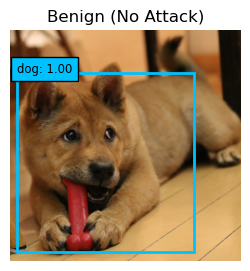

In [4]:
fpath = './assets/example_1.jpg'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes)})

In [ ]:
def evaluate_image(detector, path, attack=None):
    base_image_path = "dataset/VOCdevkit/VOC2007/JPEGImages/"
    base_annotation_path = "dataset/VOCdevkit/VOC2007/Annotations/"
    
    #array of attacks that can be launched against the model
    attacks = {
        "untargeted":tog_untargeted
    }
    
    #Preprocess the image
    im = Image.open(base_image_path + path + ".jpg")
    im, meta = letterbox_image_padded(im, size=detector.model_img_size)
    
    #Run the attack, if any
    if attack is not None:
        im = attacks[attack](victim=detector, x_query=im, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
    
    #Make detections on the image and get the ground-truth labels
    detections = detector.detect(im, conf_threshold=detector.confidence_thresh_default)
    pred_labels = detections[:, 0].flatten()
    pred_scores = detections[:, 1].flatten()
    gt_labels = np.zeros(20)
    tree = ET.parse(base_annotation_path + path + ".xml")
    root = tree.getroot()
    for object in root.findall('object/name'):
        gt_labels[class_name_to_index[object.text]-1] += 1
    
    #Record the true positives and false positives
    fps = 0
    tps = 0
    for item in pred_labels:
        if gt_labels[int(item)] == 0:
            fps += 1
        else:
            gt_labels[int(item)] -= 1
            tps += 1
    return tps, fps

tps = 0.0
fps = 0.0
for path in tqdm(os.listdir("dataset/VOCdevkit/VOC2007/JPEGImages/")):
    path = path[:-4]
    tp, fp = evaluate_image(detector, path, attack=None)
    tps += tp
    fps += fp
print("mAP is %0.4f" % (tp / (tp + fp)))

 42%|████▏     | 4209/9963 [12:54<17:47,  5.39it/s]

In [26]:
import numpy as np

def calculate_iou(box1, box2):
    #find where the boxes intersect
    min_x = box1[0] if box1[0] > box2[0] else box2[0]
    min_y = box1[1] if box1[1] > box2[1] else box2[1]
    max_x = box1[2] if box1[2] < box2[2] else box2[2]
    max_y = box1[3] if box1[3] < box2[3] else box2[3]
    
    #check to see if they overlap at all
    if min_x > max_x or min_y > max_y:
        return 0

    intersect_area = (max_x - min_x) * (max_y - min_y)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersect_area
    return float(intersect_area) / union_area

# get the average precision for a single class
def calculate_ap(pred_boxes, gt_boxes, pred_scores):

    total_precision = 0

    # sort by scores in descending order
    sorted_indices = np.argsort(pred_scores)[::-1]
    pred_boxes = np.array(pred_boxes)[sorted_indices]
    pred_scores = np.array(pred_scores)[sorted_indices]

    # pre-compute IoUs because we loop over them many times
    ious = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            ious[i, j] = calculate_iou(gt_box, pred_box)

    for iou_thresh in np.arange(0.1, 1.0, 0.1):
        num_tp = 0
        num_fp = 0
        num_gt_boxes = len(gt_boxes)
        matched_gt_boxes = [False] * num_gt_boxes

        # for every pred box, find the gt box that best aligns with it. If the IoU is greater than the threshold and the box has not
        # yet been matched, then match them and give a TP. If the best one is already matched or the IoU is not greater than the threshold
        # then it is a FP.
        for i, pred_box in enumerate(pred_boxes):
            best_iou = 0
            best_idx = -1
    
            for j, gt_box in enumerate(gt_boxes):
                iou = ious[i, j] # use pre-computed IoUs
                
                if iou > best_iou:
                    best_iou = iou
                    best_idx = j
                    #print("Best IoU for pred box", i, "is gt box", j)

            if best_iou > iou_thresh and not matched_gt_boxes[best_idx]:
                matched_gt_boxes[best_idx] = True
                #print("For IoU thresh", iou_thresh, "pred box", i, "matched gt box", best_idx, "and got a TP")
                num_tp += 1
            else:
                #print("For IoU thresh", iou_thresh, "pred box", i, "got a FP")
                num_fp += 1

        precision = num_tp / (num_tp + num_fp)
        total_precision += precision
    
    ap = total_precision / 9.0 #there are 9 thresholds between [0.1, 0.9]
    return ap

true_boxes_list = [
    [50, 50, 150, 150], [30, 30, 120, 120]  # True boxes for class 1
]

pred_boxes_list = [
    [45, 45, 155, 155], [25, 25, 125, 125]  # Predicted boxes for class 1
]

pred_scores_list = [
    0.9, 0.8
]


    

0.8888888888888888
0.0007473002187907696
